In [48]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../k6/results/run-2/ssrh/10000/'

def convert_to_MiB(value):
    if 'GiB' in value:
        return str(int(float(value.replace('GiB', '')) * 1024))
    if 'MiB' in value:
        return value.replace('MiB', '')
    return value

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

In [49]:
features = ['cpu_percent','mem_usage','mem_limit','mem_percent']
services = ["monolith", "recommendations", "teasers", "cdn", "discovery"]

df = pd.read_csv(f'{path}docker.csv', skiprows=1, names=['timestamp','name','cpu_percent','mem_usage','mem_limit','mem_percent'], sep=',')

df['mem_usage'] = df['mem_usage'].apply(convert_to_MiB).astype(float)
df['mem_limit'] = df['mem_limit'].apply(convert_to_MiB).astype(float)

df['cpu_percent'] = df['cpu_percent'].astype(float)
df['mem_percent'] = df['mem_percent'].astype(float)

start_time = df['timestamp'].min() + 60
end_time = df['timestamp'].max() - 30
df_filtered = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

dirty_dfs = {service: df_filtered[df_filtered["name"] == service].reset_index(drop=True) for service in services}

dirty_dfs['monolith'].describe()

,timestamp,cpu_percent,mem_usage,mem_limit,mem_percent
count,102.00,102.00,102.00,102.00,102.00
mean,1735123152.62,193.72,3906.48,4096.00,95.39
std,148.79,37.02,112.73,0.00,2.75
min,1735122899.00,48.60,3660.00,4096.00,89.39
25%,1735123025.25,173.15,3830.75,4096.00,93.54
50%,1735123152.50,188.42,3907.50,4096.00,95.41
75%,1735123279.75,215.75,3999.25,4096.00,97.67
max,1735123407.00,296.75,4096.00,4096.00,99.99


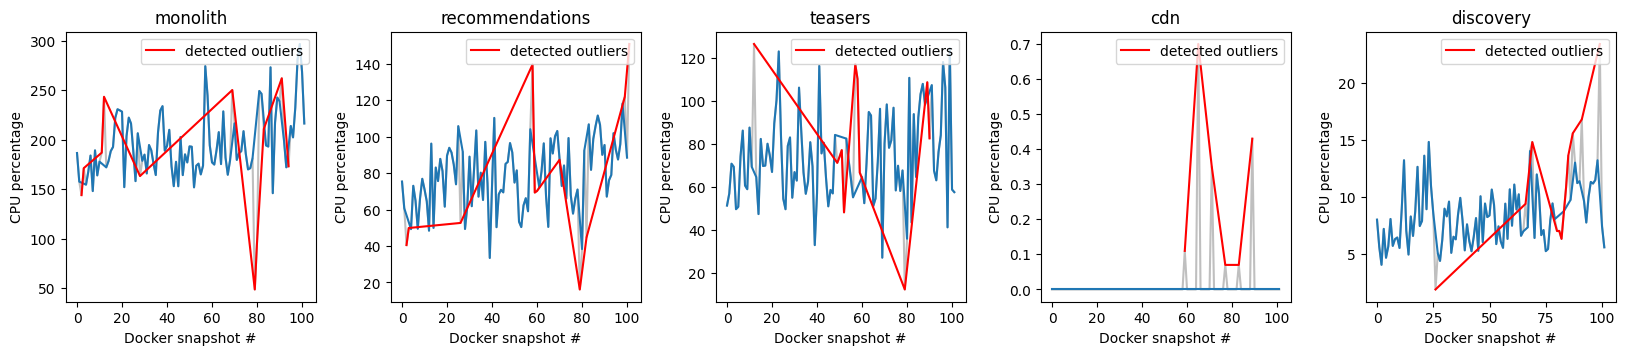

In [50]:
def plot_outliers(_df, d, loc, mask):
    loc.plot(_df['cpu_percent'], color='gray', alpha=0.5)
    loc.plot(_df['cpu_percent'][mask[d]])
    loc.plot(_df['cpu_percent'][~mask[d]], label='detected outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'CPU percentage') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

masks = {}
dfs = {}

for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

graph_row(lambda _ds, loc, idx: plot_outliers(_ds, list(dfs.keys())[idx], loc, masks), dirty_dfs)
plt.show()

In [51]:
dfs['monolith'].describe()

,timestamp,cpu_percent,mem_usage,mem_limit,mem_percent
count,91.00,91.00,91.00,91.00,91.00
mean,1735123152.81,195.71,3912.36,4096.00,95.53
std,143.87,32.07,99.68,0.00,2.43
min,1735122899.00,145.91,3729.00,4096.00,91.05
25%,1735123031.50,174.28,3842.50,4096.00,93.81
50%,1735123150.00,188.74,3909.00,4096.00,95.44
75%,1735123268.50,215.12,3996.00,4096.00,97.59
max,1735123407.00,296.75,4094.00,4096.00,99.99


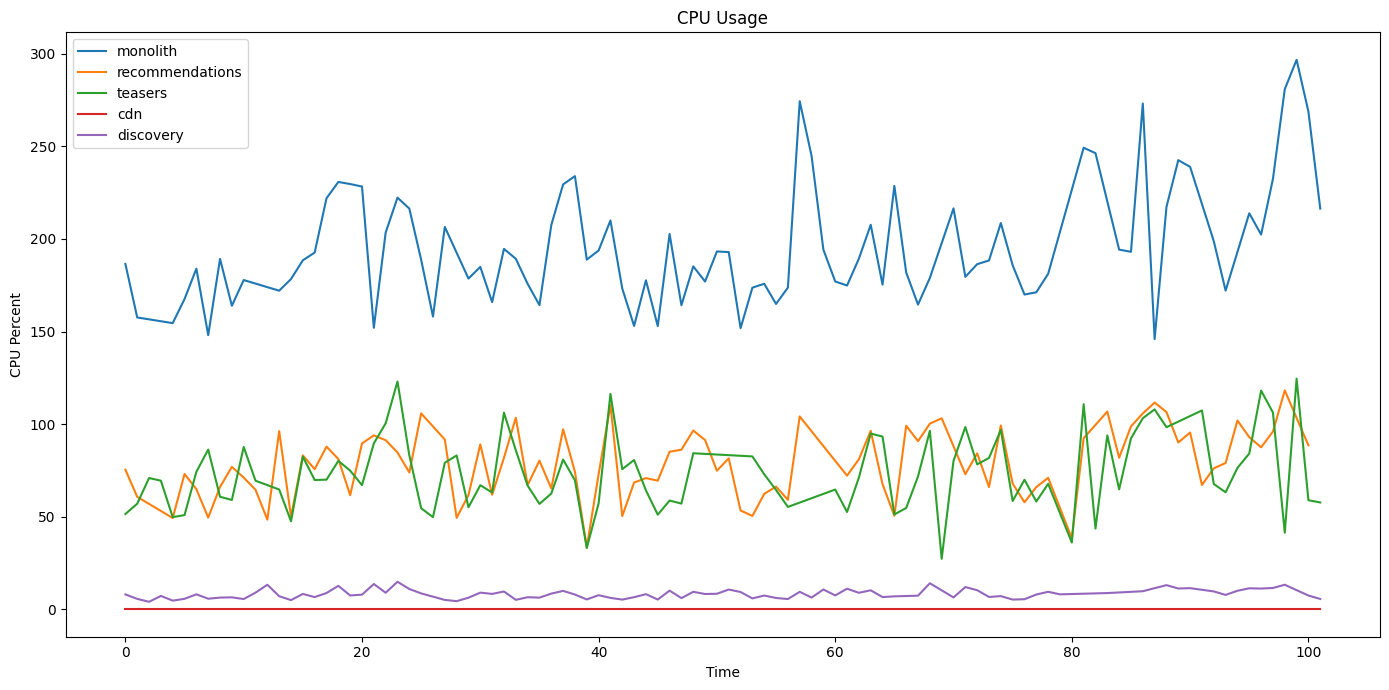

In [52]:
fig, ax = plt.subplots(figsize=(14, 7))

for s in services:
    ax.plot(dfs[s]['cpu_percent'], label=s)
ax.set_title('CPU Usage')
ax.set_xlabel('Time')
ax.set_ylabel('CPU Percent')
ax.legend()

plt.tight_layout()
plt.show()

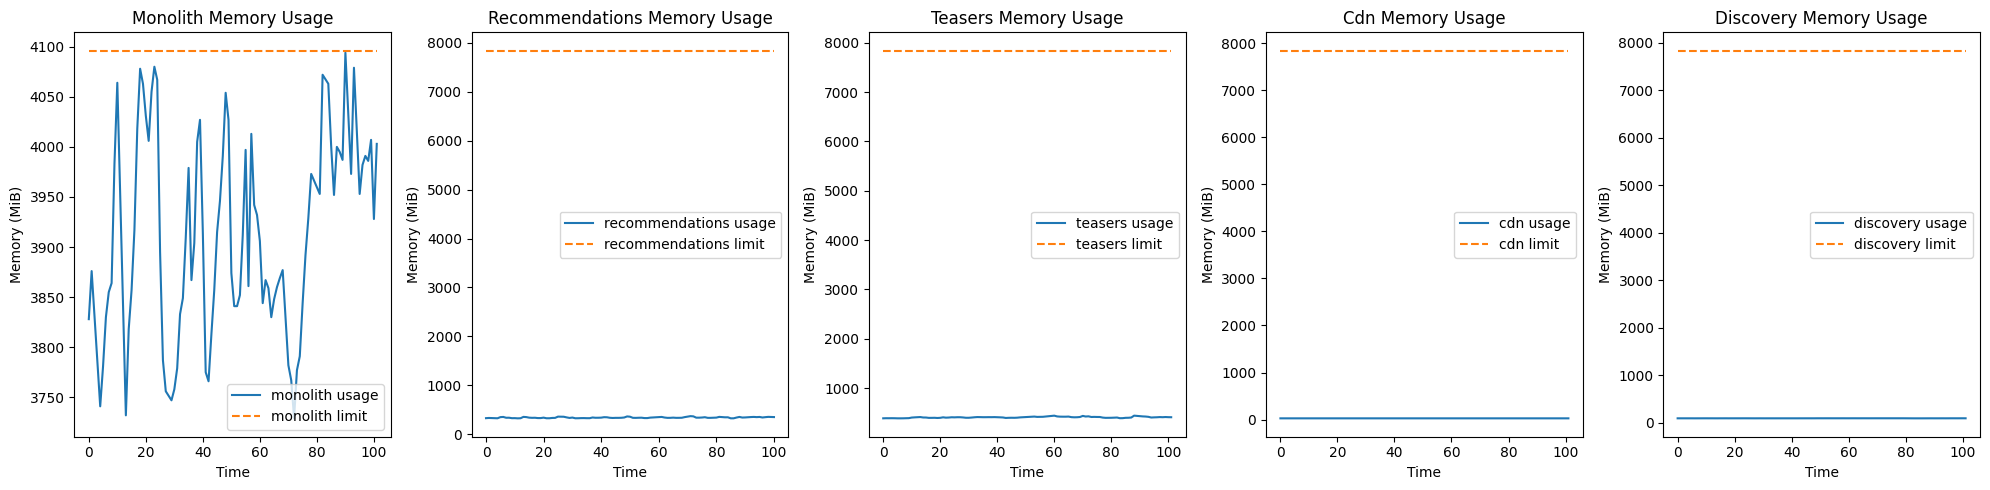

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=len(services), figsize=(20, 5))

for i, s in enumerate(services):
    axes[i].plot(dfs[s]['mem_usage'], label=f'{s} usage')
    axes[i].plot(dfs[s]['mem_limit'], linestyle='--', label=f'{s} limit')
    axes[i].set_title(f'{s.capitalize()} Memory Usage')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Memory (MiB)')
    axes[i].legend()

plt.tight_layout()
plt.show()


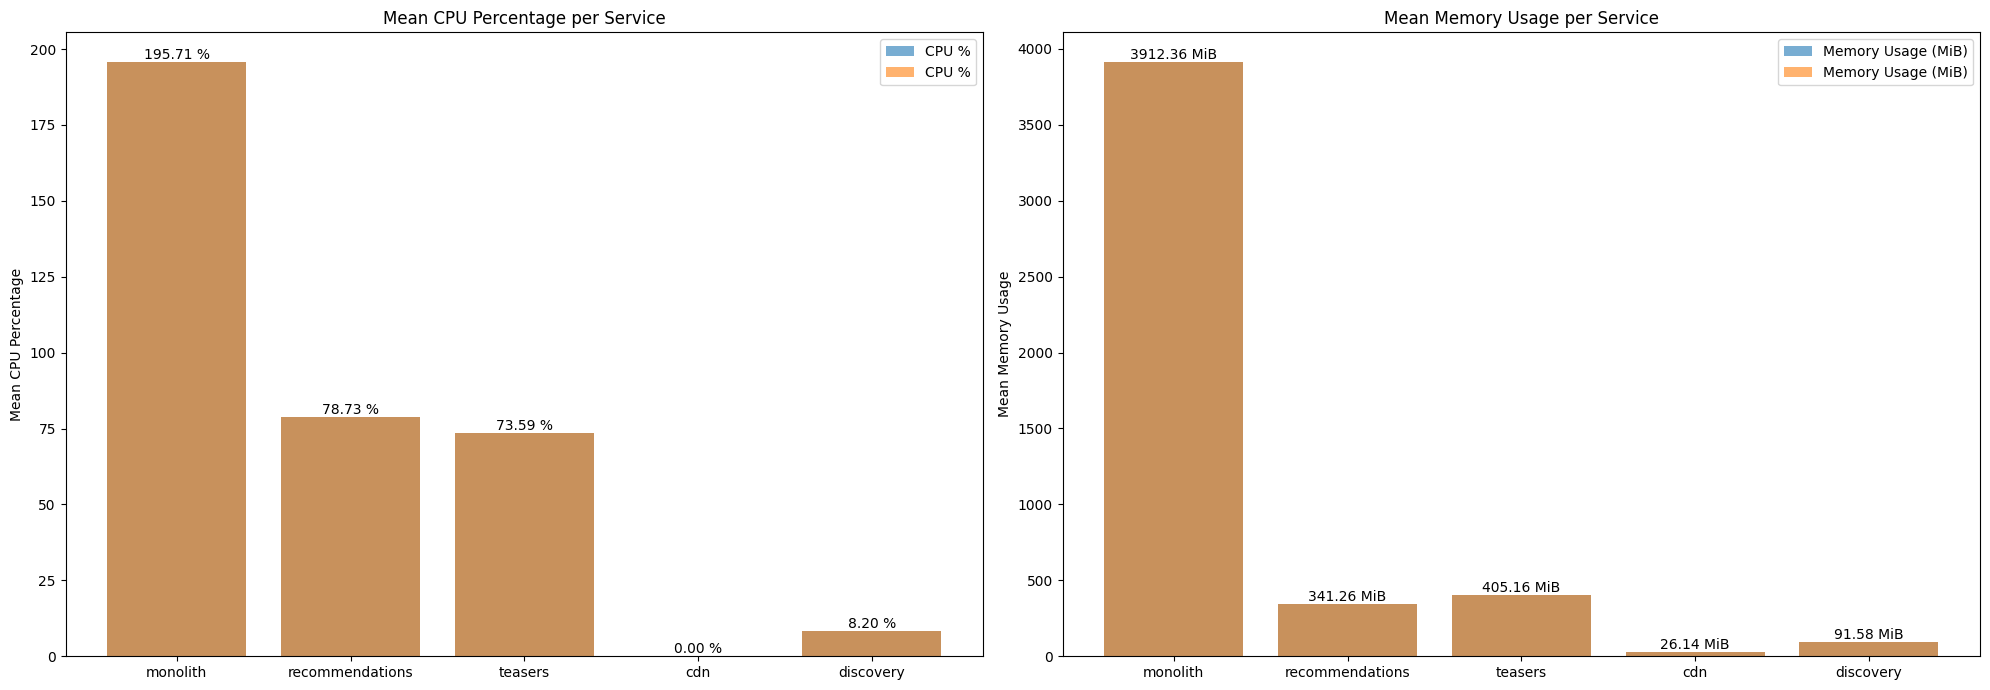

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

cpu_means = [dfs[s]['cpu_percent'].mean() for s in services]
bars_cpu = axes[0].bar(services, cpu_means, label='CPU %', alpha=0.6)
axes[0].bar(services, cpu_means, label='CPU %', alpha=0.6)
axes[0].set_title('Mean CPU Percentage per Service')
axes[0].set_ylabel('Mean CPU Percentage')
axes[0].legend()

for bar in bars_cpu:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} %', ha='center', va='bottom')

mem_means = [dfs[s]['mem_usage'].mean() for s in services]
bars_mem = axes[1].bar(services, mem_means, label='Memory Usage (MiB)', alpha=0.6)
axes[1].bar(services, mem_means, label='Memory Usage (MiB)', alpha=0.6)
axes[1].set_title('Mean Memory Usage per Service')
axes[1].set_ylabel('Mean Memory Usage')
axes[1].legend()

for bar in bars_mem:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f} MiB', ha='center', va='bottom')

plt.tight_layout()
plt.show()